An attempt at solving a Deep learning problem

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# modules required for the learning task
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for environment related stuff.
import scipy

# for visualization stuff
import matplotlib.pyplot as plt
import seaborn as sns

# keras modules required for this notebook
# Starting architecture
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import SGD


%matplotlib inline

# for checking the os files related stuff (executing shell commands)
from subprocess import check_output

Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# constant path to the data source
path = "../Data"

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [4]:
# check the files in the data source environment:
exec_command(["ls", path])

train
train_labels.csv



In [5]:
# check the structure of the train_labels.csv file
exec_command(['head', '-10', os.path.join(path, 'train_labels.csv')])

name,invasive
1,0
2,0
3,1
4,0
5,1
6,0
7,1
8,1
9,0



In [6]:
# load the labels from the csv dataset
labels_path = os.path.join(path, "train_labels.csv")
labels = pd.read_csv(labels_path).values

# check the shape of the labels....
# I am in love with the shape of you... ooo...o 
labels.shape

(2295, 2)

No. of positive examples: 1448
No. of negative examples: 847


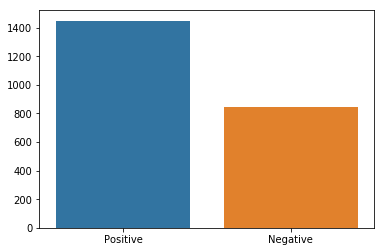

In [7]:
# check the skewness in the data. (No of positive examples and No. of negative examples)
pos_count = (labels[:, 1] == 1).sum()
neg_count = (labels[:, 1] == 0).sum()

print("No. of positive examples: %d" %pos_count)
print("No. of negative examples: %d" %neg_count)

# plot a bar chart for better view into the dataset
x_axis = ['Positive', 'Negative']
y_axis = [pos_count, neg_count]
sns.barplot(x_axis, y_axis); # semicolon to supress the output

#Alright! So, there are only half as many negative examples as the positive examples in the original complete dataset.
##Now we partition the dataset into train and cross validation datasets.

In [8]:
# shuffle the labels in the dataset:
np.random.shuffle(labels)

partition = int(labels.shape[0] * 0.70)
train_set = labels[:partition, :]
cv_set = labels[partition: , :]

print("Train Partition: %s" %str(train_set.shape))
print("cross Validation Partition: %s" %str(cv_set.shape))

Train Partition: (1606, 2)
cross Validation Partition: (689, 2)


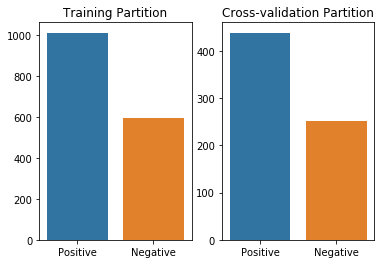

In [9]:
# now check the positive and negative distribution in the train and cross validation datatsets
p_train = (train_set[:, 1] == 1).sum()
n_train = (train_set[:, 1] == 0).sum()

p_cv = (cv_set[:, 1] == 1).sum()
n_cv = (cv_set[:, 1] == 0).sum()

fig, axs = plt.subplots(ncols=2)

# plot a bar chart for better view into the dataset
axs[0].set_title("Training Partition")
x_axis = ['Positive', 'Negative']
y_axis = [p_train, n_train]
sns.barplot(x_axis, y_axis, ax=axs[0]); # semicolon to supress the output

axs[1].set_title("Cross-validation Partition")
x_axis = ['Positive', 'Negative']
y_axis = [p_cv, n_cv]
sns.barplot(x_axis, y_axis, ax=axs[1]); # semicolon to supress the output

##Since the data was randomly shuffled before partitioning, it can be observed that the data elements skew has been preserved in the two partitions.

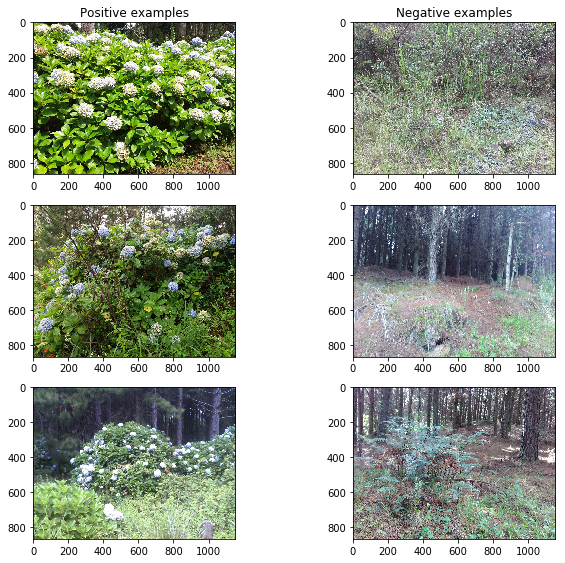

In [10]:
# visualize a few images from the training set for the positive and negative labels
pos = (train_set[train_set[:, 1] == 1, :])
neg = (train_set[train_set[:, 1] == 0, :])

# randomly pick three images from the pos set and three images from the neg set
pos_images = pos[np.random.randint(pos.shape[0], size=3), 0]
neg_images = neg[np.random.randint(neg.shape[0], size=3), 0]

# display the pos_images:
images = zip(pos_images, neg_images)

fig, axs = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(10.5, 9.5)

axs[0, 0].set_title("Positive examples")
axs[0, 1].set_title("Negative examples")

i = 0
for (pos_image, neg_image) in images:
    pos_img_path = os.path.join(path, "train", str(pos_image) + ".jpg")
    neg_img_path = os.path.join(path, "train", str(neg_image) + ".jpg")
    p_image = scipy.ndimage.imread(pos_img_path)
    n_image = scipy.ndimage.imread(neg_img_path)
    axs[i, 0].imshow(p_image); axs[i, 1].imshow(n_image)
    i += 1

shape of the input images: (100, 100, 3)


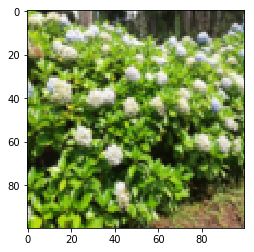

In [11]:
# check how large are the images and resize them to a standard size.
test_image = scipy.misc.imresize(scipy.ndimage.imread(os.path.join(path, "train", str(pos_images[0]) + ".jpg")), 
                                 [100, 100, 3])
plt.imshow(test_image)
print("shape of the input images: %s" %str(test_image.shape))

##OK! Enough of analysis now. Let's try building a ConvNet on this data

In [12]:
# function to load and provide batches of input images
def generate_batch(start, size, source):
    '''
        TO load the size number of images into kernel memory and return this data sturcture
        @Params
        start = the start index for batch generation
        size = number of images in the batch 
    '''
    data = np.ndarray([size, 100, 100, 3], dtype=float) # array for the images
    labels = np.empty([size], dtype=float) # array for the labels
    
    max_value = 255 # the max value of any pixel
    
    # traverse the train set to load the images:
    count = 0 # start the counter from 0
    for i in range(start, min(len(source), start + size)):
        data[count] = scipy.misc.imresize(scipy.ndimage.imread(os.path.join(path, "train", 
                         str(source[i, 0]) + ".jpg")), [100, 100, 3])
        #data[count] /= max_value # range normalize the pixel values
        labels[count] = source[i, 1]
        count += 1 # increment the counter
    
    # load the remaining images by rollover from the source
    for i in range(0, (start + size) - len(source)):
        data[count] = scipy.misc.imresize(scipy.ndimage.imread(os.path.join(path, "train", 
                         str(source[i, 0]) + ".jpg")), [100, 100, 3])
        #data[count] /= max_value # range normalize the pixel values
        labels[count] = source[i, 1]
        count += 1 # increment the counter

    return data, labels

In [12]:
# test the method defined above
# current_data, current_labels = generate_batch(1600, 100) # checking the rollover case
# print(current_data.shape)
# print(current_data[3:6], current_labels[3:6]) # check the data inside a random few images
# alright! so the data batches are getting generated quite properly.
# test successful. So, now don't run this again since kernel memory is limited

In [13]:
# using the pretrained VGG16 model
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 100, 100, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [17]:
# modify the base model to add some more fully connected layers on the bottom

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

# save the model here:

saved_path = os.path.join("../Models", "Model3")
if(not os.path.isfile(saved_path)):
    model.save_weights(saved_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [20]:
# train the model so that it sees every element in the dataset once:
batch_size = 200
total_dataset_size = len(train_set)

if(os.path.isfile(saved_path)):
    model.load_weights(saved_path)

else: 
    # let's go over the first 1000 images in the dataset
    count = 0  #start the count to 0
    for i in range(0, 8):
        print("count: " + str(i))
        x_train, y_train = generate_batch(count, batch_size, train_set)
        model.fit(x_train, y_train, epochs=2, batch_size=100); # suppress the print output.
        count = (count + batch_size) % total_dataset_size

    model.save_weights(saved_path)

count: 0
Epoch 1/2
200/200 [==============================] - 95s - loss: 0.1318 - acc: 0.9500     
Epoch 2/2
200/200 [==============================] - 95s - loss: 0.1149 - acc: 0.9550     
count: 1
Epoch 1/2
200/200 [==============================] - 94s - loss: 0.1745 - acc: 0.9350     
Epoch 2/2
200/200 [==============================] - 95s - loss: 0.1551 - acc: 0.9350     
count: 2
Epoch 1/2
200/200 [==============================] - 94s - loss: 0.1682 - acc: 0.9400     
Epoch 2/2
200/200 [==============================] - 95s - loss: 0.1511 - acc: 0.9500     
count: 3
Epoch 1/2
200/200 [==============================] - 95s - loss: 0.1217 - acc: 0.9750     
Epoch 2/2
200/200 [==============================] - 95s - loss: 0.1105 - acc: 0.9700     
count: 4
Epoch 1/2
200/200 [==============================] - 95s - loss: 0.1854 - acc: 0.9300     
Epoch 2/2
200/200 [==============================] - 95s - loss: 0.1618 - acc: 0.9250     
count: 5
Epoch 1/2
200/200 [=================

Alright, So the training iterations have now started to oscillate near the convergence point. I suppose this is enough of training.
In practice: The model was iterated through the entire dataset only twice (2 epochs). The above output is to be understood by looking at the generate_batch function.

Since, I am using a modest machine, in order not to overwhelm it with too many computations, I load only 200 images from the disk to RAM (using generate_batch). Then I train on these 200 images for 2 epochs. I continue doing the same for remaining iterations. This way, nothing crashes and everything works fine. Although a bit slow

# Lets evaluate the so trained model on the Cross validation data

In [21]:
# extract the cross_validation images from the dataset
x_eval, y_eval = generate_batch(0, 700, cv_set)

evaluation = model.evaluate(x_eval, y_eval)
acc = evaluation[1]
print('Evaluation accuracy:{0}'.format(round(acc, 4)))
print(evaluation)

700/700 [==============================] - 106s   
Evaluation accuracy:0.8986
[0.21887881321566446, 0.8985714275496347]


The evaluation accuracy on the cross validation dataset is almost 90%. 

## In the following section, I visualize a few of the kernels in the trained model to get a deeper insight into the trained classifier.

In [22]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict)

{'input_1': <keras.engine.topology.InputLayer object at 0x7fc297cfca90>, 'block1_conv1': <keras.layers.convolutional.Conv2D object at 0x7fc297cfcc18>, 'block1_conv2': <keras.layers.convolutional.Conv2D object at 0x7fc2de9140f0>, 'block1_pool': <keras.layers.pooling.MaxPooling2D object at 0x7fc297d91a58>, 'block2_conv1': <keras.layers.convolutional.Conv2D object at 0x7fc297c7d208>, 'block2_conv2': <keras.layers.convolutional.Conv2D object at 0x7fc297d5e278>, 'block2_pool': <keras.layers.pooling.MaxPooling2D object at 0x7fc297d3acc0>, 'block3_conv1': <keras.layers.convolutional.Conv2D object at 0x7fc299dfbb70>, 'block3_conv2': <keras.layers.convolutional.Conv2D object at 0x7fc299dfbeb8>, 'block3_conv3': <keras.layers.convolutional.Conv2D object at 0x7fc2960ae550>, 'block3_pool': <keras.layers.pooling.MaxPooling2D object at 0x7fc2960d4eb8>, 'block4_conv1': <keras.layers.convolutional.Conv2D object at 0x7fc29607f080>, 'block4_conv2': <keras.layers.convolutional.Conv2D object at 0x7fc29607f

In [23]:
from keras import backend as K

def iterate_function_generator(layer_name, filter_index):
    input_img  = model.input

    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]


    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    return iterate

In [24]:
import numpy as np

def generate_visualizations(layer_name, size, steps):
    # find out how many filters are present:
    # size = layer_dict[layer_name].output.shape[3]
    
    
    # create a list of empty images
    vizs = np.ndarray([size, 1, 100, 100, 3])
    # create the visualization arrays
    for i in range(size):
        # we start from a gray image with some noise
        vizs[i] = np.random.random((100, 100, 3)) * 20 + 128.
       
    print(vizs.shape)
        
    # set the step size for the gradient ascent
    step = 1

    for filter_index in range(size):
        for i in range(steps): # no. of steps
            loss_value, grads_value = iterate_function_generator(layer_name, filter_index)([vizs[filter_index]])
            vizs[filter_index] += grads_value * step
        print("current filter: " + str(filter_index + 1))            

    return vizs

In [25]:
# generate the visualizations for the layer number 1 (conv 2d)
layer1_conv_vis = generate_visualizations(model.layers[1].name, 5, 20)

(5, 1, 100, 100, 3)
current filter: 1
current filter: 2
current filter: 3
current filter: 4
current filter: 5


In [26]:
print(layer1_conv_vis[3, 0, :5, :5, 0])

[[ 150.56936197  154.44329372  172.56265488  171.48627785  164.9112608 ]
 [ 132.98691278  121.26608496  134.84079566  129.54866297  133.48411939]
 [ 136.12602426  117.44022001  116.46055863  127.16525162  127.1063871 ]
 [ 150.24164176  164.40239449  162.96741821  162.34546429  161.16825484]
 [ 149.69541333  133.34694763  147.62554449  149.45061326  140.99574677]]


In [27]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    # x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [28]:
print(layer1_conv_vis[1][0].shape)
deprocess_image(layer1_conv_vis[1][0]).shape

(100, 100, 3)


(100, 100, 3)

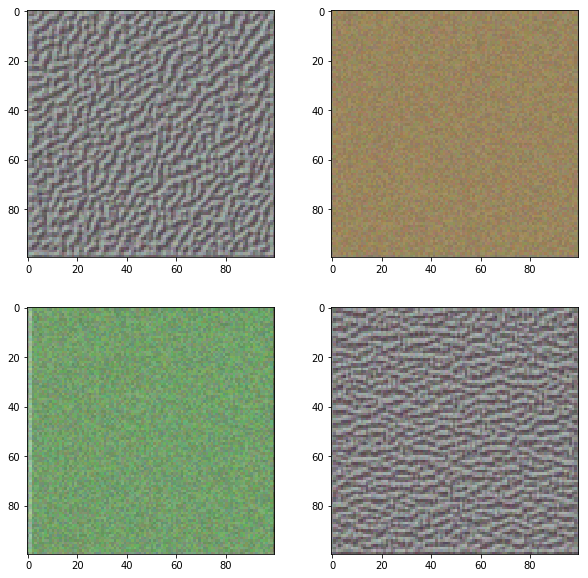

In [29]:
fig, axs = plt.subplots(ncols= 2, nrows = 2)
fig.set_size_inches(10, 10)
for i in range(2):
    for j in range(2):
        axs[i, j].imshow(deprocess_image(layer1_conv_vis[(i * 2) + j][0]));

In [30]:
# layer 17 visualizations:
last_layer_visz = generate_visualizations(model.layers[17].name, 8, 50)

(8, 1, 100, 100, 3)
current filter: 1
current filter: 2
current filter: 3
current filter: 4
current filter: 5
current filter: 6
current filter: 7
current filter: 8


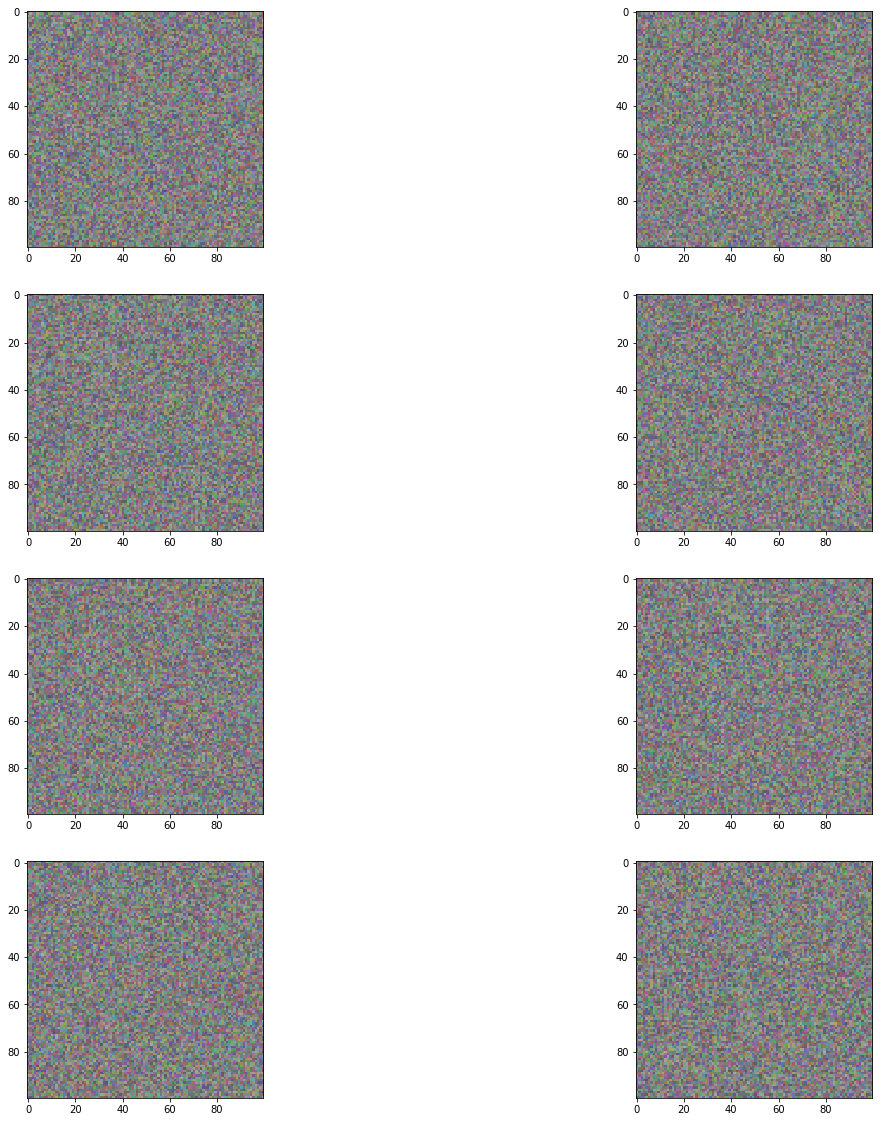

In [31]:
cols = 2; rows = 4
fig, axs = plt.subplots(ncols= cols, nrows = rows)
fig.set_size_inches(20, 20)
for i in range(rows):
    for j in range(cols):
        axs[i, j].imshow(deprocess_image(last_layer_visz[(i * cols) + j][0]));

## The above kernels are from the highest layer of the model. There don't seem to be any patterns in the kernels that I chose. Perhaps, visualizing more in the remaining 512 kernels might show something.

# Now For the las part, we generate the submission.csv file 

In [61]:
test_data_path = os.path.join(path, "test")
print(test_path) # check the path

../Data/sample_submission.csv


In [62]:
# read the sample_submission.csv file
test_path = os.path.join(path, "sample_submission.csv")
test_data = pd.read_csv(test_path).values
# test_data[:, 0]
test_data.shape

(1531, 2)

In [70]:
# now for every row in the test_data, load the image and make prediction. Then write the result to the submission.csv file
with open(os.path.join(path, 'submission.csv'), 'w') as submission:
    # write the header of the file 
    submission.write('name,invasive\n')
    
    # loop through the test_data files 
    for img in test_data[:, 0]:
        img = int(img) # cast it to integer.
    
        # load the file to be tested
        img_path = os.path.join(test_data_path, str(img) + ".jpg")
        img_file = np.ndarray([1, 100, 100, 3], dtype=float)
        img_file[0] = scipy.misc.imresize(scipy.ndimage.imread(img_path), [100, 100, 3])
        
        prediction = model.predict(img_file, verbose=1)
        print(prediction[0, 0])
    
        submission.write(str(img) + ',' + str(prediction[0, 0]) + '\n')


1/1 [==============================] - 0s
0.998413
1/1 [==============================] - 0s
0.0303007
1/1 [==============================] - 0s
0.738306
1/1 [==============================] - 0s
0.0650965
1/1 [==============================] - 0s
0.99998
1/1 [==============================] - 0s
0.25336
1/1 [==============================] - 0s
0.423546
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.108246
1/1 [==============================] - 0s
0.067574
1/1 [==============================] - 0s
0.00804563
1/1 [==============================] - 0s
0.158592
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.296106
1/1 [==============================] - 0s
0.581535
1/1 [==============================] - 0s
0.127962
1/1 [==============================] - 0s
0.11364
1/1 [==============================] - 0s
0.47724
1/1 [==============================] - 0s
0.04

1/1 [==============================] - 0s
0.016097
1/1 [==============================] - 0s
0.942049
1/1 [==============================] - 0s
0.0939417
1/1 [==============================] - 0s
0.0124779
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.0255132
1/1 [==============================] - 0s
0.418774
1/1 [==============================] - 0s
0.0725308
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.000933106
1/1 [==============================] - 0s
0.999984
1/1 [==============================] - 0s
0.266815
1/1 [==============================] - 0s
0.270261
1/1 [==============================] - 0s
0.264245
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.835244
1/1 [==============================] - 0s
0.999993
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.06550

1/1 [==============================] - 0s
0.999941
1/1 [==============================] - 0s
0.0957371
1/1 [==============================] - 0s
0.982477
1/1 [==============================] - 0s
0.999868
1/1 [==============================] - 0s
0.0471628
1/1 [==============================] - 0s
0.152478
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.644379
1/1 [==============================] - 0s
0.0351928
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.0469131
1/1 [==============================] - 0s
0.815289
1/1 [==============================] - 0s
0.0746005
1/1 [==============================] - 0s
0.174283
1/1 [==============================] - 0s
0.0253685
1/1 [==============================] - 0s
0.110128
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.121462
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.2

1/1 [==============================] - 0s
0.00540289
1/1 [==============================] - 0s
0.342697
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.152707
1/1 [==============================] - 0s
0.0950726
1/1 [==============================] - 0s
0.999998
1/1 [==============================] - 0s
0.400493
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.335463
1/1 [==============================] - 0s
0.000621964
1/1 [==============================] - 0s
0.388307
1/1 [==============================] - 0s
0.884503
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.0155035
1/1 [==============================] - 0s
0.793898
1/1 [==============================] - 0s
0.0508946
1/1 [==============================] - 0s
0.426905
1/1 [==============================] - 0s
0.999998
1/1 [==============================] - 0s
0

1/1 [==============================] - 0s
3.91125e-05
1/1 [==============================] - 0s
0.531875
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.997601
1/1 [==============================] - 0s
0.00503229
1/1 [==============================] - 0s
0.364516
1/1 [==============================] - 0s
0.999995
1/1 [==============================] - 0s
0.0133166
1/1 [==============================] - 0s
0.845205
1/1 [==============================] - 0s
0.326671
1/1 [==============================] - 0s
0.161835
1/1 [==============================] - 0s
0.0254436
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.991277
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.0640407
1/1 [==============================] - 0s
0.999998
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.4194

1/1 [==============================] - 0s
0.141851
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.321128
1/1 [==============================] - 0s
0.269459
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.997751
1/1 [==============================] - 0s
0.999948
1/1 [==============================] - 0s
0.686622
1/1 [==============================] - 0s
0.0753573
1/1 [==============================] - 0s
0.00534088
1/1 [==============================] - 0s
0.999986
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.401753
1/1 [==============================] - 0s
0.448581
1/1 [==============================] - 0s
0.999635
1/1 [==============================] - 0s
0.99624
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.0641989
1/1 [==============================] - 0s
1.0
1/1 [==

1/1 [==============================] - 0s
0.224586
1/1 [==============================] - 0s
0.419617
1/1 [==============================] - 0s
0.00660673
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.776627
1/1 [==============================] - 0s
0.0658624
1/1 [==============================] - 0s
0.0532788
1/1 [==============================] - 0s
0.999969
1/1 [==============================] - 0s
0.0792564
1/1 [==============================] - 0s
0.992717
1/1 [==============================] - 0s
0.193755
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.654186
1/1 [==============================] - 0s
0.999999
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.128001
1/1 [==============================] - 0s
0.999741
1/1 [==============================] - 0s
0.999856
1/1 [==============================] - 0s
0.11

1/1 [==============================] - 0s
0.000425421
1/1 [==============================] - 0s
0.999757
1/1 [==============================] - 0s
0.209572
1/1 [==============================] - 0s
0.2281
1/1 [==============================] - 0s
0.999995
1/1 [==============================] - 0s
0.707597
1/1 [==============================] - 0s
0.576715
1/1 [==============================] - 0s
0.000416094
1/1 [==============================] - 0s
0.267068
1/1 [==============================] - 0s
0.280256
1/1 [==============================] - 0s
0.956361
1/1 [==============================] - 0s
0.138681
1/1 [==============================] - 0s
0.999954
1/1 [==============================] - 0s
0.0518151
1/1 [==============================] - 0s
0.999982
1/1 [==============================] - 0s
0.143271
1/1 [==============================] - 0s
0.979568
1/1 [==============================] - 0s
0.0617239
1/1 [==============================] - 0s
1.0
1/1 [=========================

1/1 [==============================] - 0s
0.168118
1/1 [==============================] - 0s
0.999997
1/1 [==============================] - 0s
0.996712
1/1 [==============================] - 0s
0.019396
1/1 [==============================] - 0s
0.999996
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.998757
1/1 [==============================] - 0s
0.999989
1/1 [==============================] - 0s
0.000438755
1/1 [==============================] - 0s
0.945944
1/1 [==============================] - 0s
0.284243
1/1 [==============================] - 0s
0.0458189
1/1 [==============================] - 0s
0.0558192
1/1 [==============================] - 0s
0.15723
1/1 [==============================] - 0s
0.112994
1/1 [==============================] - 0s
0.0472192
1/1 [==============================] - 0s
0.999984
1/1 [==============================] - 0s
0.997494
1/1 [==============================] - 0s
1.0
1/1 [==============================]

1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.299981
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.999997
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.999999
1/1 [==============================] - 0s
0.999994
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.0296487
1/1 [==============================] - 0s
0.999989
1/1 [==============================] - 0s
0.559375
1/1 [==============================] - 0s
0.331412
1/1 [==============================] - 0s
0.0652591
1/1 [==============================] - 0s
0.237644
1/1 [==============================] - 0s
0.249487
1/1 [==============================] - 0s
0.163797
1/1 [==============================] - 0s
0.775121
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
1.0
1/1 [==============================] - 0s
0.766243
1/1 [===

# So, now the submission.csv file has been generated. And, I now here open this notebook further for development